In [152]:
# Third-party imports
import numpy as np
import matplotlib.pyplot as plt
import camb
import sys
sys.path.append('./hmcode/')
import utility as util
import cosmology
import linear_growth
import math

In [153]:
# Cosmology
Omega_c = 0.25
Omega_b = 0.05
Omega_k = 0.0
h = 0.7
ns = 0.96
sigma_8 = 0.8
w0 = -1.
wa = 0.
m_nu = 0.
norm_sigma8 = True
As = 2e-9

# CAMB
kmax_CAMB = 200.

# Wavenumbers [h/Mpc]
kmin, kmax = 1e-1, 1e2
nk = 128
k = np.logspace(np.log10(kmin), np.log10(kmax), nk)

# Redshifts
zs = [4., 3., 2., 1., 0.5, 0.]
zs = np.array(zs)

# Halo masses [Msun/h] (for halo model only)
#Mmin, Mmax = 1e0, 1e18
#nM = 256
#M = np.logspace(np.log10(Mmin), np.log10(Mmax), nM)

In [154]:
# Sets cosmological parameters in camb to calculate the linear power spectrum
pars = camb.CAMBparams(WantCls=False)
wb, wc = Omega_b*h**2, Omega_c*h**2

# This function sets standard and helium set using BBN consistency
pars.set_cosmology(ombh2=wb, omch2=wc, H0=100.*h, mnu=m_nu, omk=Omega_k)
pars.set_dark_energy(w=w0, wa=wa, dark_energy_model='ppf')
pars.InitPower.set_params(As=As, ns=ns, r=0.)
pars.set_matter_power(redshifts=zs, kmax=kmax_CAMB) # Setup the linear matter power spectrum
Omega_m = pars.omegam # Extract the matter density

# Scale 'As' to be correct for the desired 'sigma_8' value if necessary
if norm_sigma8:
    results = camb.get_results(pars)
    sigma_8_init = results.get_sigma8_0()
    print('Running CAMB')
    print('Initial sigma_8:', sigma_8_init)
    print('Desired sigma_8:', sigma_8)
    scaling = (sigma_8/sigma_8_init)**2
    As *= scaling
    pars.InitPower.set_params(As=As, ns=ns, r=0.)

# Run
results = camb.get_results(pars)

Running CAMB
Initial sigma_8: 0.805141810731159
Desired sigma_8: 0.8


dn/dlogM

In [155]:
datas = np.loadtxt('/home/wbc/code/HMcode-python/z_hmf.txt')

In [156]:
def Lagrangian_radius(M: np.ndarray, Om_m) -> np.ndarray:
    '''
    Radius [Mpc/h] of a sphere containing mass M in a homogeneous universe
    Args:
        M: Halo masses [Msun/h]
    '''
    return cosmology.Lagrangian_radius(M, Om_m)
    
def _get_sigmaR(R:np.ndarray, iz:int, CAMB_results:camb.CAMBdata, cold=False) -> np.ndarray:
    var='delta_nonu' if cold else 'delta_tot'
    sigmaR = CAMB_results.get_sigmaR(R, z_indices=[iz], var1=var, var2=var)[0]
    return sigmaR

def _peak_height(M: np.ndarray, sigmaM: np.ndarray, dc) -> np.ndarray:
    '''
    Calculate peak-height (nu) values from array of halo masses
    '''
    nu = dc/sigmaM
    return nu

growth = linear_growth.get_growth_interpolator(results)

In [157]:
reds = 0
a = 1

mask = datas[:, 1] > 0
datas = datas[mask]

M_hmf_intp = 10**datas[:, 0]
Om_m = 0.3089
R_hmf_intp = Lagrangian_radius(M=M_hmf_intp, Om_m=Om_m)
sM_hmf_intp = _get_sigmaR(R_hmf_intp, -1, results, cold=True)

Om_nu = results.get_Omega(var='nu', z=0.)
f_nu = Om_nu/Om_m
g = growth(a)
G = linear_growth.get_accumulated_growth(a, growth)
dc = cosmology.dc_Mead(a, Om_m, f_nu, g, G)
nu_hmf_intp = _peak_height(M_hmf_intp, sM_hmf_intp, dc=dc)

In [158]:
from scipy.special import gamma as Gamma
p = 0.3
q = 0.707
p_ST = p
q_ST = q
A_ST = np.sqrt(2.*q)/(np.sqrt(np.pi) + Gamma(0.5-p)/2**p)  # A ~ 0.2161
def st(nu):
    A = A_ST
    q = q_ST
    p = p_ST
    return A*(1.+((q*nu**2)**(-p)))*np.exp(-q*nu**2/2.)

In [159]:
rho = 277537741679.4 #Msun/h/(Mpc/h)^3
dMdnu = [util.derivative_from_samples(x=nu_hmf_intp[i], xs=nu_hmf_intp, fs=M_hmf_intp) for i in range(len(nu_hmf_intp))]

def f_nu(M, n):
    return 1/rho * n * dMdnu

In [160]:
from scipy.interpolate import splrep, splev

spl = splrep(nu_hmf_intp, M_hmf_intp)
dMdnu2 = splev(nu_hmf_intp, spl, der=1)
def f_nu_2(M, n):
    return 1/rho * n * dMdnu2

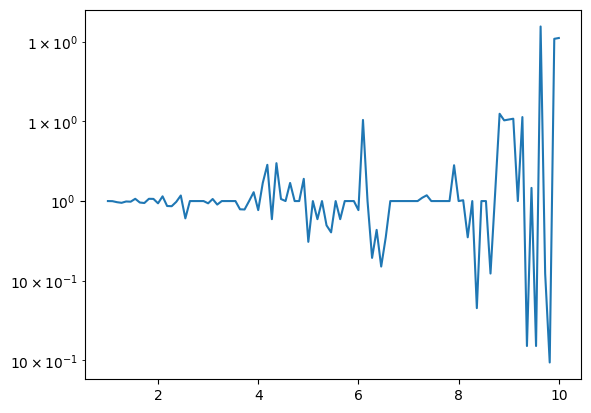

In [161]:
x = np.linspace(1, 10, 100)
y = x.copy()
dydx = [util.derivative_from_samples(x=x[i], xs=x, fs=y) for i in range(len(x))]
plt.plot(x, dydx)
plt.yscale('log')

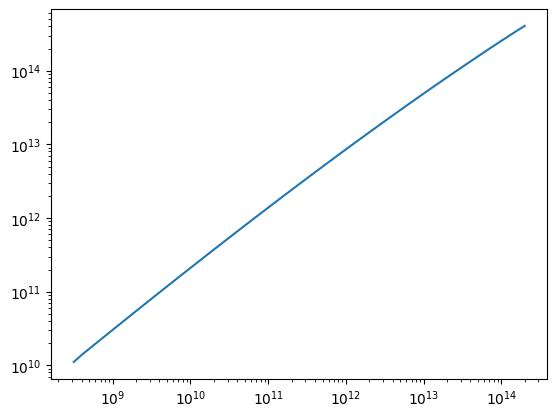

In [162]:
plt.plot(M_hmf_intp, dMdnu, label='HMcode')
plt.xscale('log')
plt.yscale('log')

In [163]:
dts = f_nu_2(M_hmf_intp, datas[:, 1])

In [168]:
np.log(10)

np.float64(2.302585092994046)

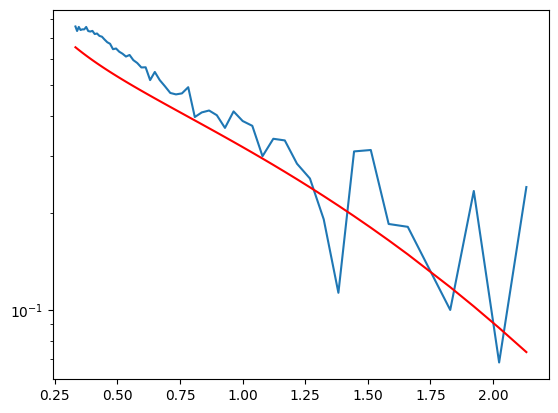

In [172]:
plt.plot(nu_hmf_intp, dts*np.log(10.), label='HMcode')
plt.plot(nu_hmf_intp, st(nu_hmf_intp), label='ST', c='r')
plt.yscale('log')

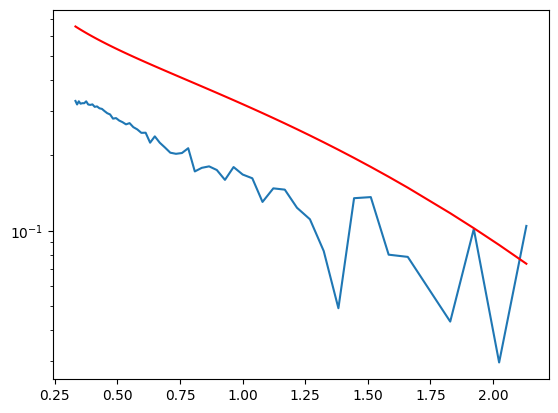

In [165]:
plt.plot(nu_hmf_intp, dts, label='HMcode')
plt.plot(nu_hmf_intp, st(nu_hmf_intp), label='ST', c='r')
plt.yscale('log')

(0.5, 1.5)

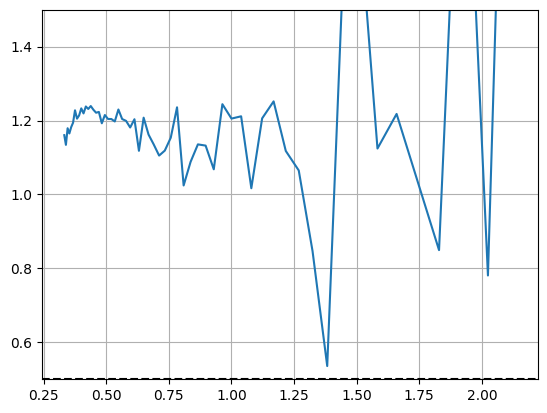

In [171]:
plt.plot(nu_hmf_intp, dts/st(nu_hmf_intp)*np.log(10), label='HMcode')
plt.grid()
plt.axhline(0.5, c='k', ls='--')
plt.ylim(0.5,1.5)